In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')
!pip install -U scikit-learn

     |████████████████████████████████| 8.0 MB 2.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


In [2]:
data = pd.read_csv('churn_prediction_simple.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22067 entries, 0 to 22066
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     22067 non-null  int64  
 1   vintage                         22067 non-null  int64  
 2   age                             22067 non-null  int64  
 3   gender                          22067 non-null  int64  
 4   dependents                      22067 non-null  float64
 5   occupation                      22067 non-null  int64  
 6   city                            22067 non-null  float64
 7   customer_nw_category            22067 non-null  int64  
 8   branch_code                     22067 non-null  int64  
 9   days_since_last_transaction     22067 non-null  float64
 10  current_balance                 22067 non-null  float64
 11  previous_month_end_balance      22067 non-null  float64
 12  average_monthly_balance_prevQ   

In [3]:
#separating dependent and independent varibales
X = data.drop(columns = ['churn','customer_id'])
Y = data['churn']

In [4]:
#Scaling the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [5]:
#splitting the dataset
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(scaled_X, Y, train_size = 0.80, stratify = Y, random_state = 101) #stratify = Y means that both the test and train set should have the target variable in equal distribution. 
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((17653, 19), (4414, 19), (17653,), (4414,))

# model building : bagging

In [6]:
from sklearn.ensemble import BaggingClassifier as BC
classifier = BC()
classifier.fit(x_train,y_train)

BaggingClassifier()

In [7]:
from sklearn.linear_model import LogisticRegression as LR

classifier = BC(base_estimator = LR(), #base_estimator is the model used to bootstrap
                n_estimators = 150, #no of model to be used to combine and for predictions
                n_jobs = -1, #no of cpu cores to be used. -1 means all cores.
                random_state = 42) #
classifier.fit(x_train, y_train)
predicted_values = classifier.predict(x_train)

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_train, predicted_values))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     14234
           1       0.75      0.08      0.15      3419

    accuracy                           0.82     17653
   macro avg       0.78      0.54      0.52     17653
weighted avg       0.80      0.82      0.75     17653



In [9]:
predicted_values = classifier.predict(x_test)
print(classification_report(y_test, predicted_values))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      3559
           1       0.78      0.09      0.16       855

    accuracy                           0.82      4414
   macro avg       0.80      0.54      0.53      4414
weighted avg       0.81      0.82      0.76      4414



why is the f1 score so low here in class 1 in both the test and train sets?

what happened?

we used a linear model with no feature transformation or engineering which means that the model is very underfitting.

# model building: random forest

In [10]:
from sklearn.ensemble import RandomForestClassifier as RFC
classifier = RFC()
classifier.fit(x_train,y_train)

RandomForestClassifier()

In [11]:
predicted_values = classifier.predict(x_train)
print(classification_report(y_train, predicted_values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14234
           1       1.00      1.00      1.00      3419

    accuracy                           1.00     17653
   macro avg       1.00      1.00      1.00     17653
weighted avg       1.00      1.00      1.00     17653



In [12]:
predicted_values = classifier.predict(x_test)
print(classification_report(y_test, predicted_values))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3559
           1       0.71      0.46      0.56       855

    accuracy                           0.86      4414
   macro avg       0.79      0.71      0.74      4414
weighted avg       0.85      0.86      0.85      4414



there is over fitting but still it perform WAYY better than bagging.

# hyperparameter tuning

In [13]:
classifier = RFC()
classifier.fit(x_train, y_train)

RandomForestClassifier()

## n_estimators

In [14]:
from sklearn.metrics import f1_score
def calc_score(model, x1, y1, x2, y2):

  model.fit(x1,y1)

  predict = model.predict(x1)
  f1 = f1_score(y1, predict)

  predict = model.predict(x2)
  f2 = f1_score(y2, predict)

  return f1, f2

In [15]:
def effect(train_score, test_score, x_axis, title):
  plt.figure(figsize = (7,4), dpi = 120)
  plt.plot(x_axis, train_score, color = 'red', label = 'train_Score')
  plt.plot(x_axis, test_score, color = 'blue', label = 'test_Score')
  plt.title(title)
  plt.legend()
  plt.xlabel("parameter_value")
  plt.ylabel("f1 score")
  plt.show()

In [16]:
estimators = [i for i in range(1,600,10)]
train = []
test = []

for i in estimators:  
  model = RFC(class_weight = 'balanced_subsample',
              n_estimators = i,
              n_jobs = -1,
              max_depth = 7,
              random_state = 101)
  f1, f2 = calc_score(model, x_train, y_train, x_test, y_test)
  train.append(f1)
  test.append(f2)

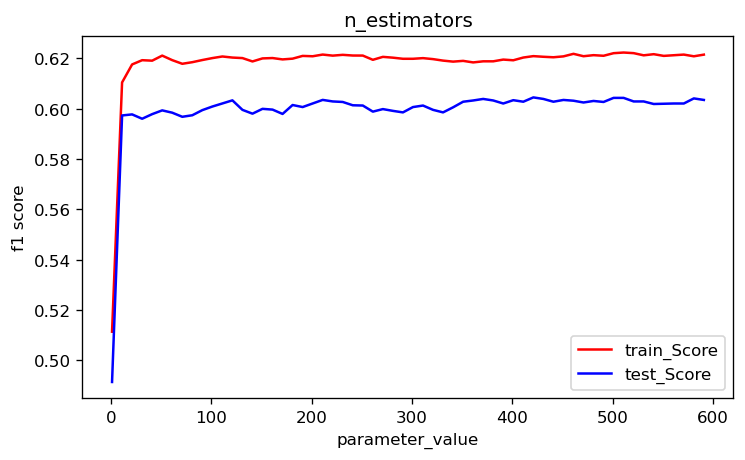

In [17]:
effect( train, test, range(1,600,10) , 'n_estimators')

## max_samples

In [18]:
maxsamples = [i/1000 for i in range(1,1000)]
train = []
test = []

for i in maxsamples:  
  model = RFC(class_weight = 'balanced_subsample', n_estimators = 50,
              n_jobs = -1, max_depth = 7, random_state = 101, max_samples = i)
  f1, f2 = calc_score(model, x_train, y_train, x_test, y_test)
  train.append(f1)
  test.append(f2)

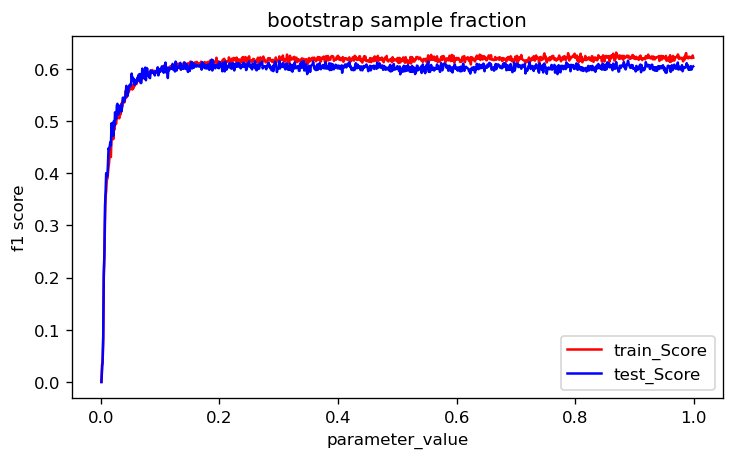

In [19]:
effect( train, test, maxsamples , 'bootstrap sample fraction')

In [20]:
maxfeatures = range(1,X.shape[1])
train = []
test = []

for i in maxfeatures:  
  model = RFC(class_weight = 'balanced_subsample', n_estimators = 50,
              n_jobs = -1, max_depth = 7, random_state = 101, max_features = i)
  f1, f2 = calc_score(model, x_train, y_train, x_test, y_test)
  train.append(f1)
  test.append(f2)

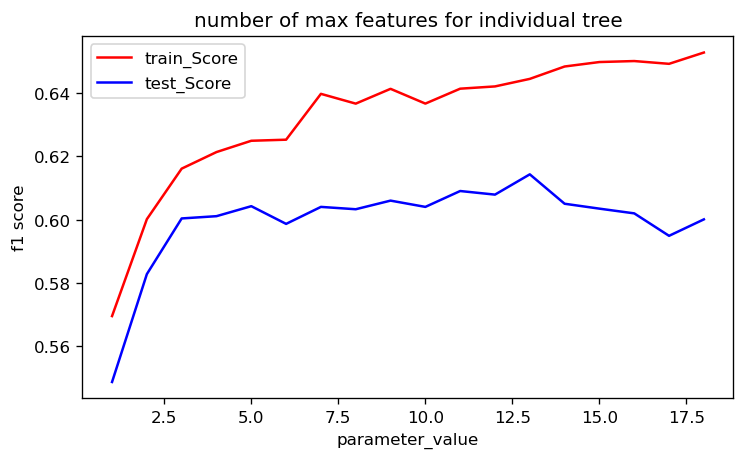

In [21]:
effect( train, test, maxfeatures , 'number of max features for individual tree')